# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

,reward,difficulty,duration,id,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


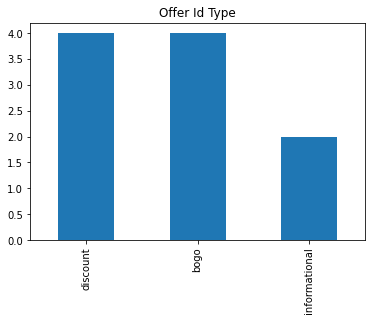

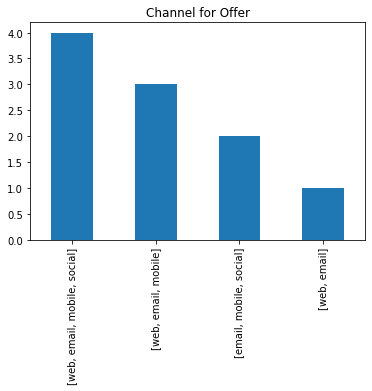

In [2]:
portfolio.head()
portfolio_new=portfolio.copy()

#create dummy variables from list object
d_chann = pd.get_dummies(portfolio_new.channels.apply(pd.Series).stack(),
                             prefix="channel").sum(level=0)
portfolio_new = pd.concat([portfolio_new, d_chann], axis=1, sort=False)


plt.figure()
    
portfolio_new.offer_type.value_counts().plot(kind='bar')
plt.title('Offer Id Type');



#dummy offer type
portfolio_new=pd.get_dummies(portfolio_new,  columns=['offer_type'])

plt.figure()
portfolio_new.channels.value_counts().plot(kind='bar')
plt.title('Channel for Offer');




#drop duplicate column
portfolio_new.drop(columns='channels', inplace=True)

portfolio_new.head()



There are twice as many bogo and discount as informational offers. Also A combination of all four channels is the most popular way to distribute offers.

In [3]:
portfolio_new.isnull().sum()

reward                      0
difficulty                  0
duration                    0
id                          0
channel_email               0
channel_mobile              0
channel_social              0
channel_web                 0
offer_type_bogo             0
offer_type_discount         0
offer_type_informational    0
dtype: int64

In [4]:
profile.head()
profile_new = profile.copy()
#convert date
date = lambda x: pd.to_datetime(str(x), format='%Y%m%d')
profile_new.became_member_on = profile_new.became_member_on.apply(date)

#dummy gender
profile_new=pd.get_dummies(profile_new,  columns=['gender'])
profile_new.head()




,age,id,became_member_on,income,gender_F,gender_M,gender_O
0,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0
1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0


In [5]:
print(profile_new.isnull().sum())




age                    0
id                     0
became_member_on       0
income              2175
gender_F               0
gender_M               0
gender_O               0
dtype: int64


In [6]:
#We will fill in NA for income
#fill in NAs in income with mean value
#profile_new.fillna(np.mean(profile_new.income), inplace=True)

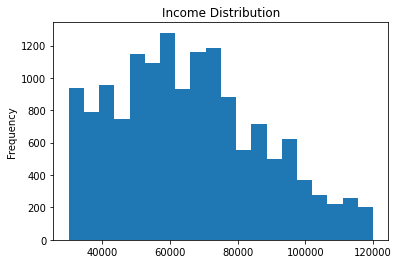

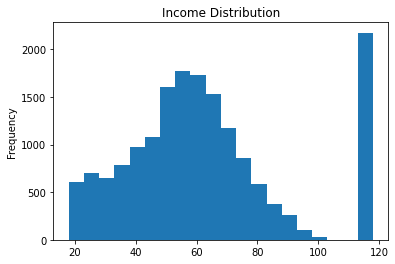

In [7]:
#visualize age and income

plt.figure()
plot=profile_new['income'].plot(kind='hist', bins=20, title='Income Distribution')

plt.figure()
plot=profile_new['age'].plot(kind='hist', bins=20, title='Income Distribution')
 

There is a big spike in the income distribution, but this is merely due to our interpolation. The spike at the end of age is puzzling, but we will keep this in our plot. When we do reccomendation, we can treat this as a separate category(maybe missing data).

In [8]:
transcript.head()
transcript_new = transcript.copy()
# dummy event variable
transcript_new=pd.get_dummies(transcript_new,  columns=['event'])


    
# Get the offer_id
transcript_new['offer_id'] = [[*v.values()][0]
                                    if [*v.keys()][0] in ['offer id',
                                                          'offer_id'] else None
                                    for v in transcript_new.value]


# Get the transaction amount
transcript_new['amount'] = [np.round([*v.values()][0], decimals=2)
                                  if [*v.keys()][0] == 'amount' else None
                                  for v in transcript_new.value]
transcript_new.drop(columns='value', inplace=True)


transcript_new

,person,time,event_offer completed,event_offer received,event_offer viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,0,0,0,1,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,0,0,0,1,None,9.53
306531,a00058cf10334a308c68e7631c529907,714,0,0,0,1,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,0,0,0,1,None,3.53


In [9]:
print(transcript_new.isnull().sum())
#we will keep NAs because they correspond to where an offer/transaction was made


person                        0
time                          0
event_offer completed         0
event_offer received          0
event_offer viewed            0
event_transaction             0
offer_id                 138953
amount                   167581
dtype: int64


In [10]:
#rename some columns with spaces
transcript_new['event_offer_completed']=transcript_new['event_offer completed']
transcript_new['event_offer_received']=transcript_new['event_offer received']
transcript_new['event_offer_viewed']=transcript_new['event_offer viewed']

transcript_new.drop(columns='event_offer completed', inplace=True)
transcript_new.drop(columns='event_offer received', inplace=True)
transcript_new.drop(columns='event_offer viewed', inplace=True)



#now we can combine the datasets into one-first we can do the transcript on profile
#rename person to id
transcript_new['id']=transcript_new['person']
transcript_new.drop(columns='person', inplace=True)


transactions = pd.merge(transcript_new, profile_new, on='id',
                          how="left")
#now use offer id to join to portfolio file

portfolio_new['offer_id']=portfolio_new['id']
portfolio_new.drop(columns='id', inplace=True)

df = pd.merge(transactions, portfolio_new, on='offer_id', how='left')
df

,time,event_transaction,offer_id,amount,event_offer_completed,event_offer_received,event_offer_viewed,id,age,became_member_on,...,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,a03223e636434f42ac4c3df47e8bac43,118,2017-08-04,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,e2127556f4f64592b11af22de27a7932,68,2018-04-26,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,8ec6ce2a7e7949b1bf142def7d0e0586,118,2017-09-25,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,68617ca6246f4fbc85e91a2a49552598,118,2017-10-02,...,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,714,1,None,1.59,0,0,0,b3a1272bc9904337b331bf348c3e8c17,66,2018-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,714,1,None,9.53,0,0,0,68213b08d99a4ae1b0dcb72aebd9aa35,52,2018-04-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,714,1,None,3.61,0,0,0,a00058cf10334a308c68e7631c529907,63,2013-09-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,714,1,None,3.53,0,0,0,76ddbd6576844afe811f1a3c0fbb5bec,57,2016-07-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#BOGO offers
df
temp=df[df['offer_type_bogo']==1]
temp.offer_id.unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       'ae264e3637204a6fb9bb56bc8210ddfd'], dtype=object)

In [12]:
#discount offers
df
temp=df[df['offer_type_discount']==1]
temp.offer_id.unique()

array(['0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [13]:
#discount offers- only half as many- this could explain the lower frequency in one of the first plots
df
temp=df[df['offer_type_informational']==1]
temp.offer_id.unique()

array(['3f207df678b143eea3cee63160fa8bed',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [14]:
#rename offer id
offer_id = {'9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo1',
       '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo2',
       'f19421c1d4aa40978ebb69ca19b0e20d':'bogo3',
       'ae264e3637204a6fb9bb56bc8210ddfd':'bogo4',
              '0b1e1539f2cc45b7b9fa7c272da2e1d7':'disc1',
       '2906b810c7d4411798c6938adc9daaa5':'disc2',
       'fafdcd668e3743c1bb461111dcafc2a4':'disc3',
       '2298d6c36e964ae4a3e7e9706d1fb8c2':'disc4',
         '3f207df678b143eea3cee63160fa8bed':'info1',
       '5a8bc65990b245e5a138643cd4eb9837':'info2'}
df.offer_id = df.offer_id.apply(lambda x: offer_id[x] if x else None)

In [15]:
df

,time,event_transaction,offer_id,amount,event_offer_completed,event_offer_received,event_offer_viewed,id,age,became_member_on,...,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,0,0,bogo1,NaN,0,1,0,78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0,0,disc1,NaN,0,1,0,a03223e636434f42ac4c3df47e8bac43,118,2017-08-04,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0,0,disc2,NaN,0,1,0,e2127556f4f64592b11af22de27a7932,68,2018-04-26,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0,0,disc3,NaN,0,1,0,8ec6ce2a7e7949b1bf142def7d0e0586,118,2017-09-25,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,0,0,bogo2,NaN,0,1,0,68617ca6246f4fbc85e91a2a49552598,118,2017-10-02,...,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,714,1,None,1.59,0,0,0,b3a1272bc9904337b331bf348c3e8c17,66,2018-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,714,1,None,9.53,0,0,0,68213b08d99a4ae1b0dcb72aebd9aa35,52,2018-04-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,714,1,None,3.61,0,0,0,a00058cf10334a308c68e7631c529907,63,2013-09-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,714,1,None,3.53,0,0,0,76ddbd6576844afe811f1a3c0fbb5bec,57,2016-07-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a bunch of null values in the dataset. However, these mostly correspond to whether the person didn't respond to the offer or if they didn't recieve it at all.

In [16]:
df.isnull().sum()

time                             0
event_transaction                0
offer_id                    138953
amount                      167581
event_offer_completed            0
event_offer_received             0
event_offer_viewed               0
id                               0
age                              0
became_member_on                 0
income                       33772
gender_F                         0
gender_M                         0
gender_O                         0
reward                      138953
difficulty                  138953
duration                    138953
channel_email               138953
channel_mobile              138953
channel_social              138953
channel_web                 138953
offer_type_bogo             138953
offer_type_discount         138953
offer_type_informational    138953
dtype: int64

# Visualizations

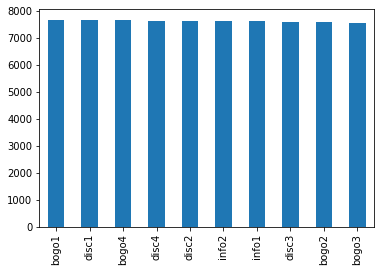

In [17]:
#all offers given at about the same frequency
df[df.event_offer_received == 1].offer_id.value_counts().plot(kind='bar')

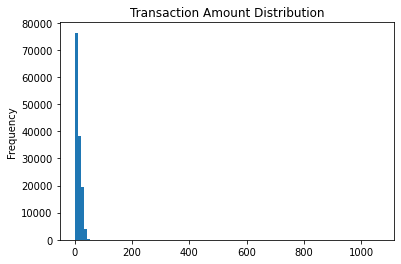

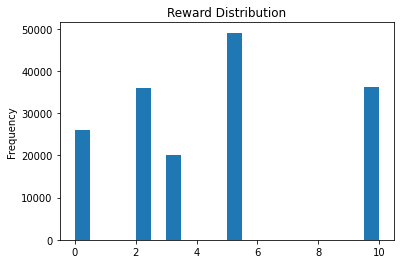

In [18]:
#look at the amount and reward

plt.figure()
plot=df['amount'].plot(kind='hist', bins=100, title='Transaction Amount Distribution')

plt.figure()
plot=df['reward'].plot(kind='hist', bins=20, title='Reward Distribution')
 

In [19]:
df.head()


,time,event_transaction,offer_id,amount,event_offer_completed,event_offer_received,event_offer_viewed,id,age,became_member_on,...,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,0,0,bogo1,NaN,0,1,0,78afa995795e4d85b5d9ceeca43f5fef,75,2017-05-09,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0,0,disc1,NaN,0,1,0,a03223e636434f42ac4c3df47e8bac43,118,2017-08-04,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0,0,disc2,NaN,0,1,0,e2127556f4f64592b11af22de27a7932,68,2018-04-26,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0,0,disc3,NaN,0,1,0,8ec6ce2a7e7949b1bf142def7d0e0586,118,2017-09-25,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,0,0,bogo2,NaN,0,1,0,68617ca6246f4fbc85e91a2a49552598,118,2017-10-02,...,10.0,10.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


## Now we can aggregate all offers by customer and how they responded to them

In [20]:
aggregate_dict = dict()
    # Get total transaction data
transactions = df[df.event_transaction == 1].groupby('id')
aggregate_dict['total_expense'] = transactions.amount.sum()
aggregate_dict['total_transactions'] = transactions.amount.count()


transactions = df.groupby('id')
aggregate_dict['total_received'] = transactions.event_offer_received.sum()
aggregate_dict['total_viewed'] = transactions.event_offer_viewed.sum()
aggregate_dict['total_completed'] = transactions.event_offer_completed.sum()

#get reward when offer is completed
transactions = df[df.event_offer_completed == 1].groupby('id')
aggregate_dict['reward'] = transactions.reward.sum()



for jj in ['bogo', 'discount', 'informational']:
    col='offer_type_'+jj
    transactions = df[df[col]==1].groupby('id')
    aggregate_dict[jj+'_received'] = transactions.event_offer_received.sum()
    aggregate_dict[jj+'_viewed'] = transactions.event_offer_viewed.sum()
    
    if jj !='informational':
        aggregate_dict[jj+'_completed'] = transactions.event_offer_completed.sum()

        #get reward when offer is completed
        transactions = df[df[col]==1]
        transactions = transactions[transactions.event_offer_completed == 1].groupby('id')
        aggregate_dict[jj+'_reward'] = transactions.reward.sum()
    
    
for jj in ['bogo1', 'disc1', 'disc2', 'disc3', 'bogo2', 'bogo3', 'disc4',
       'info1', 'bogo4', 'info2']:
    transactions = df[df['offer_id']==jj].groupby('id')
    aggregate_dict[jj+'_received'] = transactions.event_offer_received.sum()
    aggregate_dict[jj+'_viewed'] = transactions.event_offer_viewed.sum()
    
    if jj not in ['info1','info2']:
        aggregate_dict[jj+'_completed'] = transactions.event_offer_completed.sum()

        #get reward when offer is completed
        transactions = df[df['offer_id']==jj]
        transactions = transactions[transactions.event_offer_completed == 1].groupby('id')
        aggregate_dict[jj+'_reward'] = transactions.reward.sum()

In [21]:
#combine all dictionary fields
customers = pd.concat(aggregate_dict.values(), axis=1, sort=False);
customers.columns = aggregate_dict.keys()
customers.fillna(0, inplace=True)

# Add demographic data
customers = pd.merge(customers, profile.set_index('id'),left_index=True, right_index=True)
customers[['income']] = customers[['income']].fillna(value=0)


#bucket age in 10s
bins= [0,30,60,100,120]
bins2=bins[:-1]
labels = ['<30','30-60','60-100','>100']
customers['AgeGroup'] = pd.cut(customers['age'], bins=bins, labels=labels, right=False)



#bucket age in 10s
bins= [0,60000,100000,500000000]
labels = ['<60k','60k-100k','>100k']
customers['IncomeGroup'] = pd.cut(customers['income'], bins=bins, labels=labels, right=False)




In [22]:
customers

,total_expense,total_transactions,total_received,total_viewed,total_completed,reward,bogo_received,bogo_viewed,bogo_completed,bogo_reward,...,bogo4_completed,bogo4_reward,info2_received,info2_viewed,gender,age,became_member_on,income,AgeGroup,IncomeGroup
0009655768c64bdeb2e877511632db8f,127.60,8.0,5,4,3,9.0,1.0,1.0,1.0,5.0,...,0.0,0.0,1.0,1.0,M,33,20170421,72000.0,30-60,60k-100k
00116118485d4dfda04fdbaba9a87b5c,4.09,3.0,2,2,0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,None,118,20180425,0.0,>100,<60k
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5,5,3,13.0,1.0,1.0,1.0,5.0,...,0.0,0.0,1.0,1.0,O,40,20180109,57000.0,30-60,<60k
0020c2b971eb4e9188eac86d93036a77,196.86,8.0,5,3,3,14.0,2.0,1.0,1.0,10.0,...,0.0,0.0,1.0,1.0,F,59,20160304,90000.0,30-60,60k-100k
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0,4,4,3,13.0,2.0,2.0,2.0,10.0,...,0.0,0.0,1.0,1.0,F,24,20161111,60000.0,<30,60k-100k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff8bb9517a1e4ef18b63eb9f2ba67d9e,0.00,0.0,5,5,0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,F,54,20180118,85000.0,30-60,60k-100k
ff8bee9ba3754ac687d9af685b2981b7,0.00,0.0,3,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,M,64,20180531,72000.0,60-100,60k-100k
ffc6c9fbe34b4578911dcdf6745b4c74,0.00,0.0,3,2,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,F,62,20180410,57000.0,60-100,<60k
ffd810f301ad42d6bfe98c4ba6ee4125,0.00,0.0,3,3,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,M,65,20180215,52000.0,60-100,<60k


# Visualizations
Now lets look at some visualizations of the aggregated dataset

In [23]:
customers.columns

Index(['total_expense', 'total_transactions', 'total_received', 'total_viewed',
       'total_completed', 'reward', 'bogo_received', 'bogo_viewed',
       'bogo_completed', 'bogo_reward', 'discount_received', 'discount_viewed',
       'discount_completed', 'discount_reward', 'informational_received',
       'informational_viewed', 'bogo1_received', 'bogo1_viewed',
       'bogo1_completed', 'bogo1_reward', 'disc1_received', 'disc1_viewed',
       'disc1_completed', 'disc1_reward', 'disc2_received', 'disc2_viewed',
       'disc2_completed', 'disc2_reward', 'disc3_received', 'disc3_viewed',
       'disc3_completed', 'disc3_reward', 'bogo2_received', 'bogo2_viewed',
       'bogo2_completed', 'bogo2_reward', 'bogo3_received', 'bogo3_viewed',
       'bogo3_completed', 'bogo3_reward', 'disc4_received', 'disc4_viewed',
       'disc4_completed', 'disc4_reward', 'info1_received', 'info1_viewed',
       'bogo4_received', 'bogo4_viewed', 'bogo4_completed', 'bogo4_reward',
       'info2_received', 

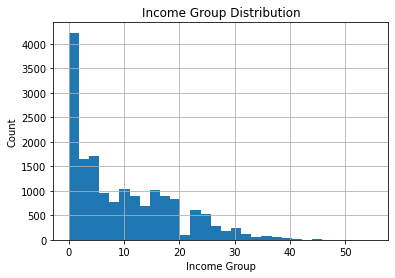

In [24]:
#reward Distribution
customers.reward.hist(bins = 30)
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group Distribution');

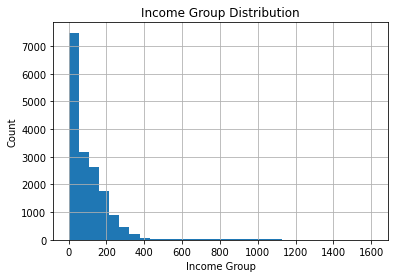

In [25]:
#total_expense Distribution
customers.total_expense.hist(bins = 30)
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group Distribution');

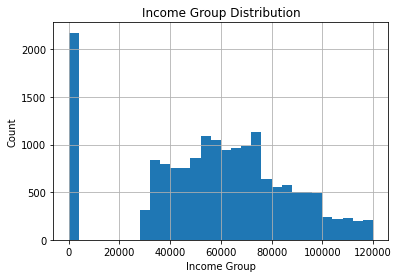

In [26]:
#Salary Distribution
customers.income.hist(bins = 30)
plt.xlabel('Income Group')
plt.ylabel('Count')
plt.title('Income Group Distribution');

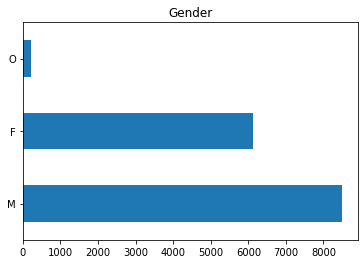

In [27]:
#Gender Distribution
customers['gender'].value_counts().plot.barh(title='Gender')

Now, I want to see which offers were completed the most frequently

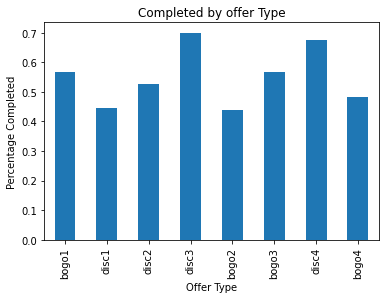

In [28]:
x=['bogo1', 'disc1', 'disc2', 'disc3', 'bogo2', 'bogo3', 'disc4', 'bogo4']

mystring='_received'
transpose = [s + mystring for s in x]


offer_received = customers[transpose].set_axis(x, axis=1, inplace=False).sum(axis=0)
mystring='_completed'
transpose = [s + mystring for s in x]


offer_completed = customers[transpose].set_axis(x, axis=1, inplace=False).sum(axis=0)


proportion = offer_completed/offer_received
proportion.plot(kind='bar')
plt.ylabel('Percentage Completed')
plt.xlabel('Offer Type')
plt.title('Completed by offer Type');

Discount code 3 had highest completetion rate, followed by Discount 2. Bogo2 had the lowest. 

/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


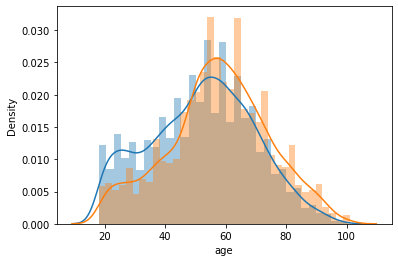

In [29]:
#Lets look at some segmented distributions
## Gender-wise age distribution
import seaborn as sns
sns.distplot(customers[customers.gender=='M'].age,label='Male')
sns.distplot(customers[customers.gender=='F'].age,label='Female')


/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


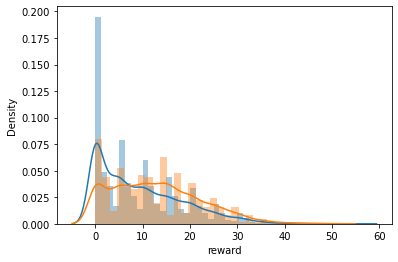

In [30]:
#Lets look at some segmented distributions
## Gender-wise age distribution
import seaborn as sns
sns.distplot(customers[customers.gender=='M'].reward,label='Male')
sns.distplot(customers[customers.gender=='F'].reward,label='Female')

# Reccomendation System
- now we will create a reccomendation system 
- first we will do it overall for the whole dataset
- base it on total expense

In [117]:
def get_average_expense(customers, offer):
    """ Get the total_expense for customers that viewed and completed and offer- completed at least one transaction
    Input:
    - offer type
    Returns:
    - total_expense average
    """
    flag = (customers['{}_viewed'.format(offer)] > 0)
    flag = flag & (customers.total_expense > 0)
    flag = flag & (customers.total_transactions >= 1)
    if offer not in ['info1', 'info2']:
        flag = flag & (customers['{}_completed'.format(offer)] > 0)
    return customers[flag].total_expense.mean()


def top_offers(customers, n=2):
    """ Sort offers based on the ones that result in the highest average expense
    Input:
    - customers: dataframe 
    - n_top: number of offers to be returned
    Returns:
    - offer list
    """
    offers = ['bogo1', 'disc1', 'disc2', 'disc3', 'bogo2', 'bogo3', 'disc4',
    'info1', 'bogo4', 'info2']
        
    
    offers.sort(key=lambda x: get_average_expense(customers, x), reverse=True)
    offers_dict = {o: get_average_expense(customers, o) for o in offers}
    return offers_dict

top_offers(customers, n=10)

{'bogo4': 182.19803376714734,
 'disc1': 181.22352581521733,
 'bogo2': 179.80589026548648,
 'disc2': 162.0258385093168,
 'bogo1': 154.5920247603833,
 'bogo3': 153.1574801641585,
 'disc3': 150.25683510038385,
 'disc4': 143.2920217945746,
 'info1': 116.02414018161146,
 'info2': 105.51707014388492}

- what if we wanted to optimize response rate?

In [118]:
def get_average_completion(customers, offer):
    """ Get the total_expense for customers that viewed and completed and offer- completed at least one transaction
    Input:
    - offer type
    Returns:
    - total_expense average
    """
    flag = (customers['{}_viewed'.format(offer)] > 0)
    flag = flag & (customers.total_expense > 0)
    flag = flag & (customers.total_transactions >= 1)
    #flag = flag & (customers['{}_completed'.format(offer)] > 0)
    c=customers[flag]
    c['rate']=c['{}_completed'.format(offer)]/c['{}_received'.format(offer)]
    return c[flag].rate.mean()


def top_offers_completion(customers, n=2):
    """ Sort offers based on the ones that result in the highest average expense
    Input:
    - customers: dataframe 
    - n_top: number of offers to be returned
    Returns:
    - offer list
    """
    offers = ['bogo1', 'disc1', 'disc2', 'disc3', 'bogo2', 'bogo3', 'disc4','bogo4']
        
    
    offers.sort(key=lambda x: get_average_completion(customers, x), reverse=True)
    offers_dict = {o: get_average_completion(customers, o) for o in offers}
    return offers_dict

top_offers_completion(customers, n=10)

/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


{'disc3': 0.7214234083958856,
 'disc4': 0.6972379997772582,
 'bogo1': 0.671713615023474,
 'disc2': 0.6595545977011494,
 'disc1': 0.6117035110533161,
 'bogo3': 0.5882938522278625,
 'bogo4': 0.49062443926072125,
 'bogo2': 0.45254823240771713}

# Reccomendations by Segments

 Now we can look at reccomendations split by gender, income, and age

In [119]:
#male
top_offers(customers.loc[(customers['gender']=='M')  ], n=10)

{'bogo4': 179.83622403560847,
 'bogo2': 178.2392290076336,
 'disc1': 177.82514824797838,
 'disc2': 155.82460526315793,
 'bogo1': 148.7281937602628,
 'bogo3': 144.4273692900388,
 'disc3': 143.23866343184824,
 'disc4': 132.4780265567763,
 'info1': 121.70241765071498,
 'info2': 98.39727982954538}

In [120]:
#female
top_offers(customers.loc[(customers['gender']=='F')  ], n=10)

{'disc1': 187.75707715133544,
 'bogo4': 185.92214235376994,
 'bogo2': 183.55129986244825,
 'disc2': 178.1990790697672,
 'bogo3': 176.13472308649648,
 'disc3': 175.86033824331665,
 'bogo1': 171.18860444444465,
 'disc4': 171.04378095762226,
 'info1': 149.55521505376336,
 'info2': 143.83504733432966}

In [121]:
top_offers(customers.loc[(customers['gender']=='F') & (customers['IncomeGroup']=='<60k') ], n=10)

{'bogo4': 155.02868932038834,
 'disc1': 154.93723404255323,
 'bogo2': 143.3326439790577,
 'bogo3': 136.71606653620353,
 'disc3': 131.6194680851065,
 'disc4': 130.980051457976,
 'disc2': 127.92329153605017,
 'bogo1': 125.1076836158192,
 'info1': 116.10885117493478,
 'info2': 106.61441958041962}

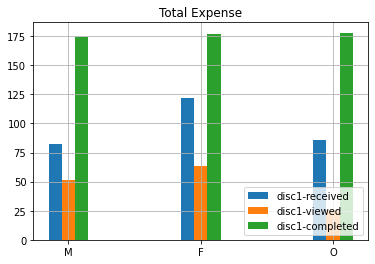

In [122]:
def plot_offer(customers, variable, offertype, grouping):
    """ look at cusomers by different offer response behavior
    Input:
    - customers df
    - variable: ie total_expense to aggreage with
    - offertype
    - grouping variable
    Output:
    - viewed, received
    """

    received_col = '{}_received'.format(offertype)
    viewed_col = '{}_viewed'.format(offertype)
    completed_col = '{}_completed'.format(offertype)


    #only received an offer
    received = (customers[received_col] > 0) & (customers[viewed_col] == 0)

    #viewed by not completed
    viewed =(customers[viewed_col] > 0) & (customers[completed_col] == 0)
    completed = (customers[completed_col] > 0)
    #completed an offer
    completed = customers[completed].groupby(grouping)[variable].mean()
    received = customers[received].groupby(grouping)[variable].mean()
    viewed = customers[viewed].groupby(grouping)[variable].mean()

    return received, viewed, completed


received, viewed, completed = plot_offer(customers, 'total_expense', 'disc1', 'gender')

index = np.array([0,1,2])
bar_width = 0.1


plt.bar(index, received.reindex(['M', 'F', 'O']), bar_width, label='disc1-received')
plt.bar(index + bar_width, viewed.reindex(['M', 'F', 'O']), bar_width, label='disc1-viewed')
plt.bar(index + 2*bar_width, completed.reindex(['M', 'F', 'O']), bar_width, label='disc1-completed')
plt.grid();
plt.legend(loc='lower right');
plt.title('Total Expense');
plt.xticks(index + bar_width, ('M', 'F', 'O'));



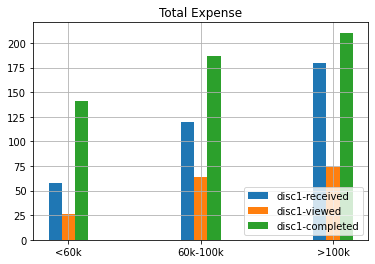

In [123]:
received, viewed, completed = plot_offer(customers, 'total_expense', 'disc1', 'IncomeGroup')


plt.bar(index, received.reindex(['<60k','60k-100k','>100k']), bar_width, label='disc1-received')
plt.bar(index + bar_width, viewed.reindex(['<60k','60k-100k','>100k']), bar_width, label='disc1-viewed')
plt.bar(index + 2*bar_width, completed.reindex(['<60k','60k-100k','>100k']), bar_width, label='disc1-completed')
plt.grid();
plt.legend(loc='lower right');
plt.title('Total Expense');
plt.xticks(index + bar_width, ('<60k','60k-100k','>100k'));



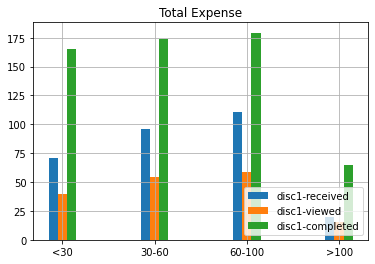

In [124]:
received, viewed, completed = plot_offer(customers, 'total_expense', 'disc1', 'AgeGroup')
index=np.array([0,1,2,3])
list2=['<30','30-60','60-100','>100']

plt.bar(index, received.reindex(['<30','30-60','60-100','>100']), bar_width, label='disc1-received')
plt.bar(index + bar_width, viewed.reindex(['<30','30-60','60-100','>100']), bar_width, label='disc1-viewed')
plt.bar(index + 2*bar_width, completed.reindex(['<30','30-60','60-100','>100']), bar_width, label='disc1-completed')
plt.grid();
plt.legend(loc='lower right');
plt.title('Total Expense');
plt.xticks(index + bar_width, ('<30','30-60','60-100','>100'));





Now, let's test our reccomendations to see if we can create a higher expense than originally generated by the offers; we will give whatever offer is suggested by the reccomendation engine

In [179]:
from IPython.display import clear_output


customers
customers.shape[0]
customers['newoffer']=""
customers['newexpense']=0
for j in range(customers.shape[0]):
    clear_output()
    print(j)
    age=customers['AgeGroup'][j]
    income=customers['IncomeGroup'][j]
    gend=customers['gender'][j]

    
    cust=customers.copy()
    cust=cust.loc[(customers['IncomeGroup']==income)]



    if customers['AgeGroup'][j]!='>100':
        cust=cust.loc[(customers['AgeGroup']==age)]
    if customers['gender'][j] is not None:
        cust=cust.loc[(customers['gender']==gend)]
    offer=top_offers(cust, n=10)
    
    q=0
    val=list(offer.values())[0]
    
    while not(list(offer.values())[q]>0):
        q=q+1
        val=list(offer.values())[q]
        

    customers['newexpense'][j]=list(offer.values())[q]
    customers['newoffer'][j]=list(offer.keys())[q]
    
        
    
customers

16999


,total_expense,total_transactions,total_received,total_viewed,total_completed,reward,bogo_received,bogo_viewed,bogo_completed,bogo_reward,...,info2_received,info2_viewed,gender,age,became_member_on,income,AgeGroup,IncomeGroup,newoffer,newexpense
0009655768c64bdeb2e877511632db8f,127.60,8.0,5,4,3,9.0,1.0,1.0,1.0,5.0,...,1.0,1.0,M,33,20170421,72000.0,30-60,60k-100k,disc1,188
00116118485d4dfda04fdbaba9a87b5c,4.09,3.0,2,2,0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,None,118,20180425,0.0,>100,<60k,bogo4,149
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5,5,3,13.0,1.0,1.0,1.0,5.0,...,1.0,1.0,O,40,20180109,57000.0,30-60,<60k,disc3,144
0020c2b971eb4e9188eac86d93036a77,196.86,8.0,5,3,3,14.0,2.0,1.0,1.0,10.0,...,1.0,1.0,F,59,20160304,90000.0,30-60,60k-100k,bogo4,205
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.0,4,4,3,13.0,2.0,2.0,2.0,10.0,...,1.0,1.0,F,24,20161111,60000.0,<30,60k-100k,bogo2,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff8bb9517a1e4ef18b63eb9f2ba67d9e,0.00,0.0,5,5,0,0.0,2.0,2.0,0.0,0.0,...,0.0,0.0,F,54,20180118,85000.0,30-60,60k-100k,bogo4,205
ff8bee9ba3754ac687d9af685b2981b7,0.00,0.0,3,3,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,M,64,20180531,72000.0,60-100,60k-100k,disc1,194
ffc6c9fbe34b4578911dcdf6745b4c74,0.00,0.0,3,2,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,F,62,20180410,57000.0,60-100,<60k,bogo4,139
ffd810f301ad42d6bfe98c4ba6ee4125,0.00,0.0,3,3,0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,M,65,20180215,52000.0,60-100,<60k,bogo4,146


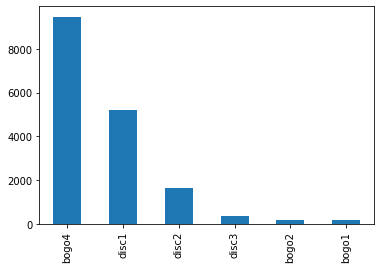

In [191]:
customers['newoffer'].value_counts().plot(kind='bar')

/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


New Reccomendations result in increase of 70.5% total expense


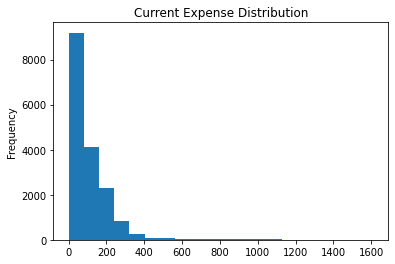

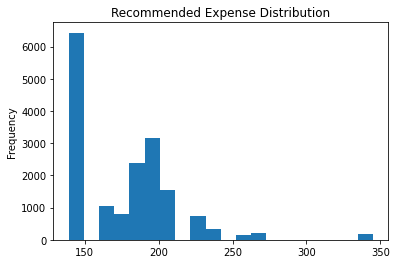

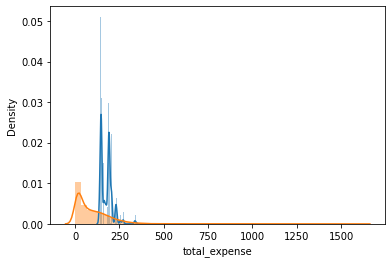

In [215]:
customers['newexpense'].sum()

plt.figure()
plot=customers['total_expense'].plot(kind='hist', bins=20, title='Current Expense Distribution')
plt.figure()
plot=customers['newexpense'].plot(kind='hist', bins=20, title='Recommended Expense Distribution')

plt.figure()
import seaborn as sns
sns.distplot(customers['newexpense'],label='New Expense')
sns.distplot(customers.total_expense,label='Total Expense')

#print(f'The value of pi is approximately {math.pi:.3f}.')
x=(sum(customers['newexpense'])/sum(customers.total_expense)-1)*100
print(f'New Reccomendations result in increase of {x:.1f}% total expense')

After removing 0 observations, New Reccomendations result in increase of 66.3% total expense


/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nicholasreimold/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


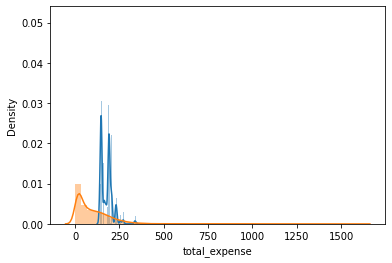

In [217]:
#what if we ignore cases where nothing was done(ie total_expense=0)

cust2=customers.loc[(customers['total_expense']>0)]


x=(sum(cust2['newexpense'])/sum(cust2.total_expense)-1)*100
print(f'After removing 0 observations, New Reccomendations result in increase of {x:.1f}% total expense')


plt.figure()
import seaborn as sns
sns.distplot(cust2['newexpense'],label='New Expense')
sns.distplot(cust2.total_expense,label='Total Expense')